In [190]:
import os
import random
import itertools
import pandas as pd
import re
import json
import warnings
warnings.filterwarnings("ignore")
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap = cm.get_cmap('bwr')

params = {
    'legend.fontsize': '15',
    'figure.figsize': (15, 8),
     'axes.labelsize': '20',
     'axes.titlesize':'30',
     'xtick.labelsize':'18',
     'ytick.labelsize':'18',
}
plt.rcParams.update(params)
import seaborn as sns
# sns.set_palette("Spectral")
# sns.set_style('whitegrid')
sns.set_style()

In [97]:
import sklearn.datasets as skd
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import normalize
from sklearn.datasets import load_iris

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
dev = qml.device("default.qubit", wires=4)

In [4]:
# from sklearn.datasets import load_boston
from sklearn.datasets import load_iris
# from sklearn.datasets import load_diabetes
# from sklearn.datasets import load_digits
from sklearn.datasets import load_linnerud
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer

In [5]:
from MEngCode import encoding as encoder
from MEngCode import pennyLaneQVC as QVC
from MEngCode import PoincarePlot as pp
from MEngCode import Helpers2 as h2

In [6]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])
    
@qml.qnode(dev)
def circuit(weights, angles=None):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(var, angles=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles=angles) + bias


def cost(weights, features, labels):
    predictions = [variational_classifier(weights, angles=f) for f in features]
    return square_loss(labels, predictions)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [7]:
def normandpad(X):
    if str(type(X)) =="<class 'pandas.core.frame.DataFrame'>":
        X = X.values
    ## stokes
    # X = ellip_train[:, 0:2]


#     print("First X sample (original)  :", X[0])

    # pad the vectors to size 2^2 with constant values
    padding = 0.3 * np.ones((len(X), 1))
    X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
#     print("First X sample (padded)    :", X_pad[0])

    # normalize each input
    normalization = np.sqrt(np.sum(X_pad ** 2, -1))
    X_norm = (X_pad.T / normalization).T
#     print("First X sample (normalized):", X_norm[0])

    # angles for state preparation are new features
    features = np.array([get_angles(x) for x in X_norm])
#     print("First features sample      :", features[0])

    return padding, X, X_pad, normalization, X_norm, features

def preparedata(x, y, rotation):
    cols = []
    for i in range(x.shape[1]):
        cols.append("f"+str((i+1)))
    
    datas = pd.DataFrame(np.c_[x,y], columns=cols + ['target'])
    datas = datas[datas['target'] > 0]
    Y = datas['target'].values
    Y = np.array(2*(Y-1)-1, dtype=np.int8)
    datas = datas.values[:, 0:2]


    ## rotated 
    datas = np.c_[[np.array(rotate([0,0], point, rotation)) for point in datas]]
    
    scaler = MinMaxScaler()
    #scaler = MaxAbsScaler()
    #scaler = StandardScaler()
    #scaler = RobustScaler()

    datas = pd.DataFrame(scaler.fit_transform(datas),columns=['f1', 'f2'])
    padding, X, X_pad, normalization, X_norm, features = normandpad(datas)
    return padding, X, X_pad, normalization, X_norm, features, Y

# Create Data

In [8]:
class ParamsCreate:
    def __init__(self, features):
        self.samples = 400
        self.centers = 3
        self.features = features
        self.rngstate = 11
        self.center = (-3.5, 3.5)

In [9]:
pc = ParamsCreate(4)
x,y = skd.make_blobs(n_samples=pc.samples, centers=pc.centers, 
                     n_features=pc.features, random_state=pc.rngstate, center_box=pc.center)

In [10]:
rotation = -90

# Prepare

In [11]:
class ParamsTrain:
    def __init__(self, X, Y, features, rotation, layers=6):
        self.X = X
        self.Y = Y
        self.num_data = len(self.Y)
        self.features = features
        self.num_train = int(0.75 * self.num_data)
        self.index = np.random.permutation(range(self.num_data))
        self.feats_train = self.features[self.index[:self.num_train]]
        self.Y_train = self.Y[self.index[:self.num_train]]
        self.feats_val = self.features[self.index[self.num_train:]]
        self.Y_val = self.Y[self.index[self.num_train:]]

        
        self.X_train = self.X[self.index[:self.num_train]]
        self.X_val = self.X[self.index[self.num_train:]]
        
        self.num_qubits = 2
        self.num_layers = layers
        self.var_init = (0.01 * np.random.randn(self.num_layers, self.num_qubits, 3), 0.0)
        
        self.opt = NesterovMomentumOptimizer(0.01)
        self.batch_size = 5
        self.var = self.var_init
        self.runData = []

In [12]:
padding, X, X_pad, normalization, X_norm, features, Y = preparedata(x, y, rotation=rotation)

# Train

In [70]:
def train(pt, epochs=60, verbose=False):
    np.random.seed(0)
    results = {}
    for it in range(epochs):
        runResults = {
            "Iter": "",
            "cost": "",
            "Acc Training": "",
            "Acc Validation": ""
        }

        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, pt.num_train, (pt.batch_size,))
        feats_train_batch = pt.feats_train[batch_index]
        Y_train_batch = pt.Y_train[batch_index]
        pt.var = pt.opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), pt.var)

        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier(pt.var, angles=f)) for f in pt.feats_train]
        predictions_val = [np.sign(variational_classifier(pt.var, angles=f)) for f in pt.feats_val]

        # Compute accuracy on train and validation set
        acc_train = accuracy(pt.Y_train, predictions_train)
        acc_val = accuracy(pt.Y_val, predictions_val)

        iteration = it+1
        finalcost = cost(pt.var, pt.features, pt.Y)

        if verbose:
            print(
                "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
                "".format(iteration, finalcost, acc_train, acc_val)
            )
        runResults["Iter"] = iteration
        runResults["cost"] = finalcost
        runResults["Acc Training"] = acc_train
        runResults["Acc Validation"] = acc_val
        pt.runData.append(runResults)
        
    results[str(rotation)] = pt.runData
    print("Rotation: {}\t finished".format(str(rotation)))
    return results

In [71]:
pt = ParamsTrain(X, Y, features, rotation)

In [72]:
# results = train(pt)

KeyboardInterrupt: 

# Save

In [75]:
def saveResults(pt, rotation):
    y_pred = np.array([QVC.variational_classifier(pt.var, angles=f) for f in pt.feats_val])
    y_pred[y_pred < 0.0] = -1
    y_pred[y_pred > 0] = 1
    results[str(rotation)+"|pred"] = list(y_pred)
    results[str(rotation)+"|true"] = list(np.array(pt.Y_val, dtype=np.float))
    with open(r"RotationTests/rotate"+str(rotation)+".json", 'w+') as fp:
        json.dump(results, fp)

In [ ]:
# saveResults(pt, rotation)

# Read

In [ ]:
def readRes():
    subdir = r"RotationTests/"
    files = [pos_json for pos_json in os.listdir(subdir) if pos_json.endswith('.json')]
    jsons = []
    for f in files:
        with open(subdir + f) as jsonf:
            jsons.append(json.load(jsonf))
    return jsons
    

In [65]:
# finalresults = readRes()

In [66]:
# for res in finalresults:
#     rot = list(res.keys())[0]
#     y_pred_k = list(res.keys())[1]
#     y_true_k = list(res.keys())[2]
#     y_true = res[y_true_k]
#     y_pred = res[y_pred_k]
#     fpr, tpr, _ = roc_curve(y_true, y_pred)
#     auc = auc(fpr, tpr)
    
#     plt.figure(figsize=(12,8))
#     lw = 2
#     plt.plot(fpr, tpr, color='darkcyan',
#              lw=lw, label="ROC "+rot+" curve (area = %0.2f)" % auc)

# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right", fontsize=18)
# plt.show()

TypeError: 'numpy.float64' object is not callable

In [67]:
finalresults

[{'-90': [{'Iter': 1,
    'cost': 1.6663789159644617,
    'Acc Training': '',
    'Acc Validation': 0.4626865671641791,
    'Acc Traing': 0.507537688442211},
   {'Iter': 2,
    'cost': 1.6266363544286968,
    'Acc Training': '',
    'Acc Validation': 0.4626865671641791,
    'Acc Traing': 0.507537688442211},
   {'Iter': 3,
    'cost': 1.5353797302449788,
    'Acc Training': '',
    'Acc Validation': 0.4626865671641791,
    'Acc Traing': 0.49748743718592964},
   {'Iter': 4,
    'cost': 1.3843941375779856,
    'Acc Training': '',
    'Acc Validation': 0.40298507462686567,
    'Acc Traing': 0.4824120603015075},
   {'Iter': 5,
    'cost': 1.2901269681534395,
    'Acc Training': '',
    'Acc Validation': 0.373134328358209,
    'Acc Traing': 0.45226130653266333},
   {'Iter': 6,
    'cost': 1.205217643225768,
    'Acc Training': '',
    'Acc Validation': 0.373134328358209,
    'Acc Traing': 0.4221105527638191},
   {'Iter': 7,
    'cost': 1.152388245753555,
    'Acc Training': '',
    'Acc Vali

# By (-90,+90) - 3 degrees

In [102]:
pc = ParamsCreate(4)
x,y = skd.make_blobs(n_samples=pc.samples, centers=pc.centers, 
                     n_features=pc.features, random_state=pc.rngstate, center_box=pc.center)

In [103]:
for rotation in range(-90, 93, 3):
    padding, X, X_pad, normalization, X_norm, features, Y = preparedata(x, y, rotation=rotation)
    pt = ParamsTrain(X, Y, features, rotation)
    results = train(pt, epochs=60)
    saveResults(pt, rotation)

Rotation: -90	 finished
Rotation: -87	 finished
Rotation: -84	 finished
Rotation: -81	 finished
Rotation: -78	 finished
Rotation: -75	 finished
Rotation: -72	 finished
Rotation: -69	 finished
Rotation: -66	 finished
Rotation: -63	 finished
Rotation: -60	 finished
Rotation: -57	 finished
Rotation: -54	 finished
Rotation: -51	 finished
Rotation: -48	 finished
Rotation: -45	 finished
Rotation: -42	 finished
Rotation: -39	 finished
Rotation: -36	 finished
Rotation: -33	 finished
Rotation: -30	 finished
Rotation: -27	 finished
Rotation: -24	 finished
Rotation: -21	 finished
Rotation: -18	 finished
Rotation: -15	 finished
Rotation: -12	 finished
Rotation: -9	 finished
Rotation: -6	 finished
Rotation: -3	 finished
Rotation: 0	 finished
Rotation: 3	 finished
Rotation: 6	 finished
Rotation: 9	 finished
Rotation: 12	 finished
Rotation: 15	 finished
Rotation: 18	 finished
Rotation: 21	 finished
Rotation: 24	 finished
Rotation: 27	 finished
Rotation: 30	 finished
Rotation: 33	 finished
Rotation: 3

In [104]:
finalresults = readRes()

In [142]:
dats = []
for res in finalresults:

    rot = list(res.keys())[0]
    y_pred_k = list(res.keys())[1]
    y_true_k = list(res.keys())[2]
    
    y_true = res[y_true_k]
    y_pred = res[y_pred_k]

    fpr, tpr, _ = roc_curve(y_true, y_pred)
#     print(auc(fpr, tpr))
    auc_score = auc(fpr, tpr)
    
    cr = classification_report(y_true, y_pred, output_dict=True)
    p1 = list(cr['-1.0'].values())
    m1 = list(cr['-1.0'].values())
    acc = cr['accuracy']
    dats.append([rot, acc, m1[0], m1[1], m1[2], p1[0], p1[1], p1[2], auc_score])

In [146]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        37

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



In [209]:
df = pd.DataFrame(dats,columns=["Rotation", "Accuracy", "Precision (-1)", "Recall (-1)", "F1-Score (-1)",
                                "Precision (+1)", "Recall (+1)", "F1-Score (+1)", "AUC"])

df.Rotation = pd.to_numeric(df.Rotation)
df = df.round(3)
df.sort_values(by="Rotation")

,Rotation,Accuracy,Precision (-1),Recall (-1),F1-Score (-1),Precision (+1),Recall (+1),F1-Score (+1),AUC
29,-90,0.925,0.879,0.967,0.921,0.879,0.967,0.921,0.929
27,-87,0.910,1.000,0.800,0.889,1.000,0.800,0.889,0.900
26,-84,0.881,0.867,0.867,0.867,0.867,0.867,0.867,0.879
25,-81,0.851,1.000,0.667,0.800,1.000,0.667,0.800,0.833
24,-78,0.940,0.906,0.967,0.935,0.906,0.967,0.935,0.943
...,...,...,...,...,...,...,...,...,...
55,78,0.970,1.000,0.933,0.966,1.000,0.933,0.966,0.967
56,81,0.896,1.000,0.767,0.868,1.000,0.767,0.868,0.883
57,84,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
58,87,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


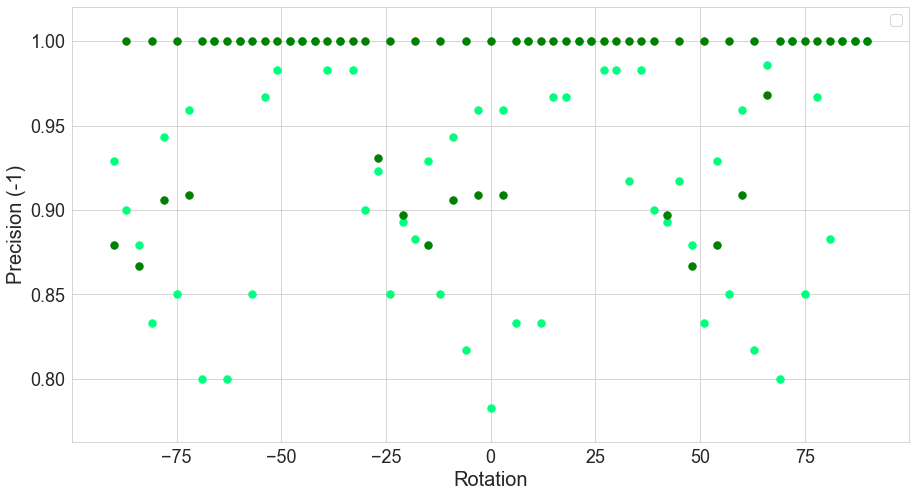

In [238]:
ax = df.plot.scatter(x="Rotation", y="AUC", s=55, c="springgreen")
# df.plot.scatter(x="Rotation", y="Accuracy", c="red", s=55, ax=ax)
df.plot.scatter(x="Rotation", y="Precision (-1)", c="green", s=55, ax=ax)
# df.plot.scatter(x="Rotation", y="Recall (-1)", c="blue", s=55, ax=ax)
# df.plot.scatter(x="Rotation", y="F1-Score (-1)", c="slateblue", s=55, ax=ax)
# df.plot.scatter(x="Rotation", y="Precision (+1)", c="black", s=55, ax=ax)
# df.plot.scatter(x="Rotation", y="Recall (+1)", c="purple", s=55, ax=ax)
# df.plot.scatter(x="Rotation", y="F1-Score (+1)", c="brown", s=55, ax=ax)
ax.legend()

In [208]:
df.plot.(x=["Rotation", "Accuracy"], y='AUC')

SyntaxError: invalid syntax (<ipython-input-208-d481b20d87b1>, line 1)

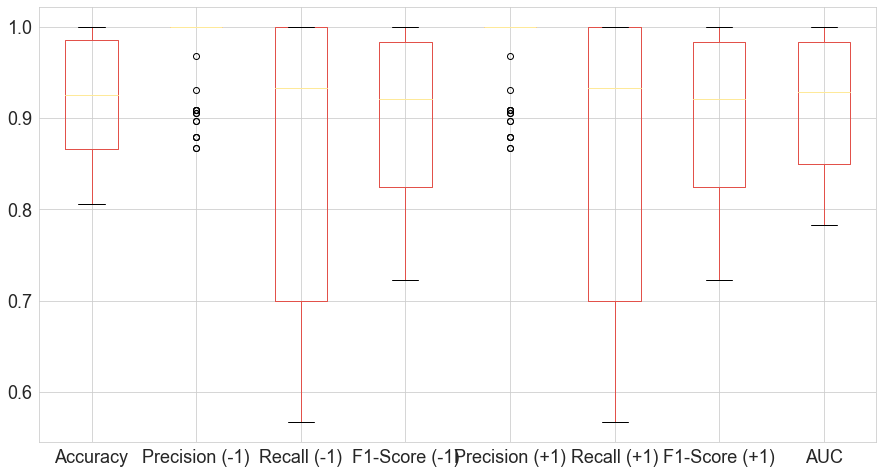

In [199]:
df.plot.box(x="Rotation")

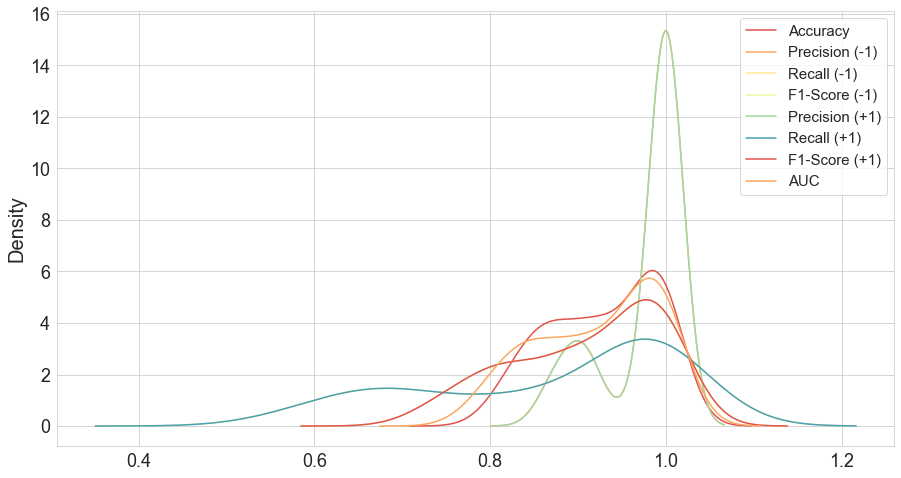

In [198]:
df.plot.density(x="Rotation")

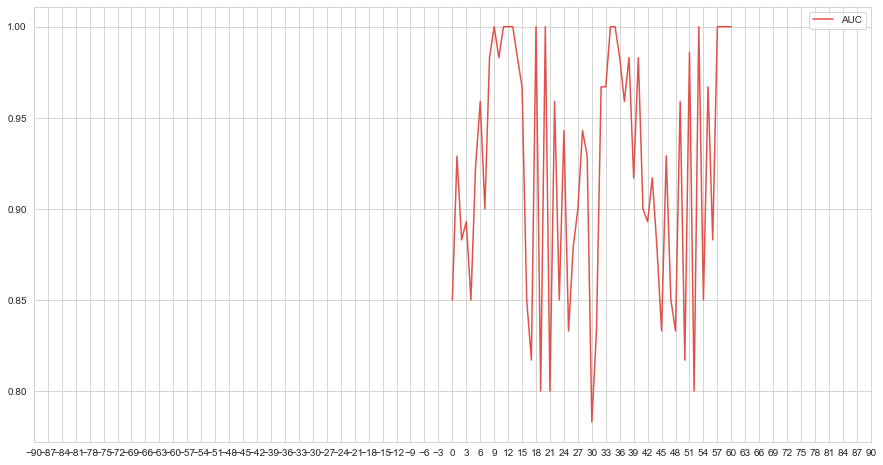

In [187]:
ax = df[["AUC"]].plot(figsize=(15,8))

ax.set_xticks(sorted(list(df["Rotation"])))
plt.show()

In [177]:
np.arange(sorted(list(df["Rotation"])))

TypeError: unsupported operand type(s) for -: 'list' and 'int'